In [1]:
import numpy as np
import pandas as pd
import os
from config import data_path
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
# Load options data, original format
df_option = pd.read_parquet(os.path.join(data_path, 'SPY_options.parquet'))
df_option = df_option[df_option['EXPIRE_DATE'] != '2015-12-19']
df_option = df_option[df_option['EXPIRE_DATE'] != '2018-12-23']

In [3]:
# Load SPY price data
df_stock = pd.read_pickle(os.path.join(data_path, 'spy_1d.pkl'))
df_stock['ts'] = pd.to_datetime(df_stock['ts'].dt.date)
df_stock['log_return'] = np.log(df_stock['close_price']/df_stock['close_price'].shift(1))
df_stock['rv'] = df_stock['log_return'].ewm(span=21, adjust=False).std() * np.sqrt(252)
df_stock = df_stock[(df_stock['ts']>='2010-01-01')&(df_stock['ts']<='2022-12-31')].copy()

In [4]:
df_vix = pd.read_csv(os.path.join(data_path, 'VIX_History.csv'))
df_vix['ts'] = pd.to_datetime(df_vix['DATE'])
df_vix['vix'] = df_vix['CLOSE']/100
df_vix = df_vix[['ts','vix']]

In [5]:
df_sq = pd.read_csv(os.path.join(data_path, 'sqzme.csv'))
df_sq['ts'] = pd.to_datetime(df_sq['date'])
df_sq = df_sq[['ts','gex']]

In [6]:
df_label = pd.merge(df_stock, df_vix, on='ts', how='inner')
df_label = pd.merge(df_label, df_sq, on='ts', how='inner')
# Volatility Risk Premium (VRP = IV - RV)
df_label['VRP'] = df_label['vix'] - df_label['rv']
df_label.head()

,ts,close_price,log_return,rv,vix,gex,VRP
0,2011-05-02,136.220001,-0.001540,0.097546,0.1599,1.897313e+09,0.062354
1,2011-05-03,135.729996,-0.003604,0.096693,0.1670,1.859731e+09,0.070307
2,2011-05-04,134.830002,-0.006653,0.099833,0.1708,1.717764e+09,0.070967
3,2011-05-05,133.610001,-0.009090,0.105812,0.1820,1.361864e+09,0.076188
4,2011-05-06,134.199997,0.004406,0.103070,0.1840,1.490329e+09,0.080930


In [7]:
def select_atm_option(group):
    # First get the minimum STRIKE_DISTANCE_PCT for this date
    min_distance = group['STRIKE_DISTANCE_PCT'].min()
    atm_options = group[group['STRIKE_DISTANCE_PCT'] == min_distance]
    
    # Among ATM options, try to find those within 2-14 DTE
    valid_dte = atm_options[(atm_options['DTE'] >= 2) & (atm_options['DTE'] <= 14)]
    
    if len(valid_dte) > 0:
        # If we have options in range, select the one with minimum DTE
        return valid_dte.loc[valid_dte['DTE'].idxmin()]
    else:
        # If no options in range, find the one with DTE closest to target range
        atm_options['DTE_DIFF'] = atm_options['DTE'].apply(lambda x: min(abs(x-2), abs(x-14)))
        result = atm_options.loc[atm_options['DTE_DIFF'].idxmin()]
        return result.drop('DTE_DIFF')

# Apply the selection to get ATM options with desired DTE
df_option_atm = df_option.groupby('QUOTE_DATE', group_keys=False).apply(select_atm_option)

In [8]:
date_list = pd.Index(df_option_atm['QUOTE_DATE'].unique()).intersection(df_label['ts'])
df_option_atm = df_option_atm[df_option_atm['QUOTE_DATE'].isin(date_list)].reset_index(drop=True)

<Axes: title={'center': 'DTE Distribution'}, xlabel='DTE'>

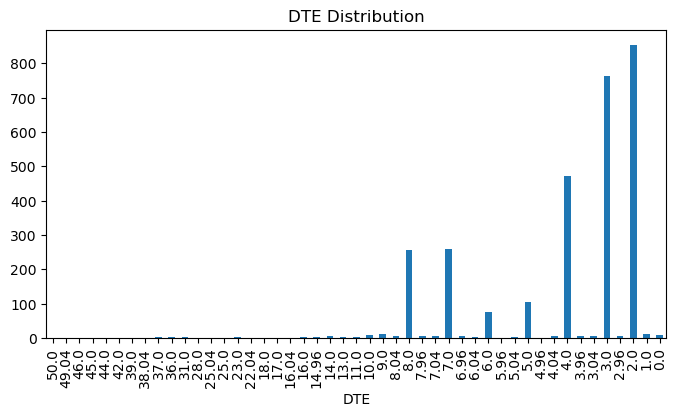

In [9]:
df_option_atm['DTE'].value_counts().sort_index(ascending=False).plot.bar(title='DTE Distribution', figsize=(8, 4))

In [10]:
df_next_option = pd.DataFrame()

for i in range(len(date_list)-1):
    date = date_list[i]
    next_date = date_list[i+1]
    atm_option = df_option_atm[df_option_atm['QUOTE_DATE'] == date]
    
    next_day_option = df_option[
        (df_option['QUOTE_DATE'] == next_date) &
        (df_option['STRIKE'] == atm_option['STRIKE'].values[0]) &
        (df_option['EXPIRE_DATE'] == atm_option['EXPIRE_DATE'].values[0])
    ]
    
    if len(next_day_option) > 0:
        df_next_option = pd.concat([df_next_option, next_day_option])

df_next_option = df_next_option.reset_index(drop=True)

In [11]:
# Calculate low & high GEX thresholds
df_label['gex_low'] = df_label['gex'].rolling(window=21).quantile(0.05)
df_label['gex_high'] = df_label['gex'].rolling(window=21).quantile(0.95)

# Generate trade signal
def generate_signal(row):
    if row['gex'] < row['gex_low'] and row['VRP'] < 0:
        return 1
    elif row['gex'] > row['gex_high'] and row['VRP'] > 0:
        return -1
    else:
        return 0

df_label['signal'] = df_label.apply(generate_signal, axis=1)
df_label['signal'] = df_label['signal'].shift(1).fillna(0)

In [12]:
df_label['signal'].value_counts()

signal
 0.0    2747
-1.0     169
 1.0       9
Name: count, dtype: int64

In [13]:
for i in range(len(date_list)-1):
    date = date_list[i]
    next_date = date_list[i+1]
    atm_option = df_option_atm[df_option_atm['QUOTE_DATE'] == date]
    next_option = df_next_option[(df_next_option['QUOTE_DATE'] == next_date)]
    if len(next_option) > 0:
        flag = df_label[df_label['ts'] == date]['signal'].values[0]
        if flag == 1:
            enter_pnl = - 1 * (atm_option['C_ASK'].values[0] + atm_option['P_ASK'].values[0])
            exit_pnl = 1 * (next_option['C_BID'].values[0] + next_option['P_BID'].values[0])
        elif flag == -1:
            enter_pnl = 1 * (atm_option['C_BID'].values[0] + atm_option['P_BID'].values[0])
            exit_pnl = - 1 * (next_option['C_ASK'].values[0] + next_option['P_ASK'].values[0])
        else:
            enter_pnl, exit_pnl = 0, 0
    else:
        enter_pnl, exit_pnl = 0, 0

    pnl = exit_pnl + enter_pnl
    df_label.loc[df_label['ts'] == next_date, 'pnl'] = pnl

In [ ]:
# Create a copy of the data for plotting
df = df_label[['ts', 'close_price', 'pnl', 'signal']].copy()

# Calculate cumulative PnL
df['cum_pnl'] = df['pnl'].cumsum()

# Create interactive plot with plotly
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add Cumulative PnL on primary y-axis
fig.add_trace(
    go.Scatter(
        x=df['ts'], 
        y=df['cum_pnl'], 
        name='Strategy PnL',
        line=dict(color='black', width=2)
    ),
    secondary_y=False
)

# Add SPY line on secondary y-axis
fig.add_trace(
    go.Scatter(
        x=df['ts'], 
        y=df['close_price'], 
        name='SPY',
        line=dict(color='gray', width=2)
    ),
    secondary_y=True
)

# Plot long straddle trades
long_days = df[df['signal'] == 1]
fig.add_trace(
    go.Scatter(
        x=long_days['ts'], 
        y=long_days['cum_pnl'], 
        mode='markers',
        name='Long Straddle',
        marker=dict(color='green', size=8)
    ),
    secondary_y=False
)

# Plot short straddle trades
short_days = df[df['signal'] == -1]
fig.add_trace(
    go.Scatter(
        x=short_days['ts'], 
        y=short_days['cum_pnl'], 
        mode='markers',
        name='Short Straddle',
        marker=dict(color='red', size=8)
    ),
    secondary_y=False
)

# Update layout
fig.update_layout(
    title="Straddle Strategy vs. SPY",
    xaxis_title="Date",
    legend=dict(x=1.05, y=0.99),
    hovermode="x unified",
    template="plotly_white",
    width=1000,
    height=600
)

# Update y-axes titles
fig.update_yaxes(title_text="Strategy PnL ($)", secondary_y=False)
fig.update_yaxes(title_text="SPY Price", secondary_y=True)

fig.show()
# fig.write_html('straddle_strategy_plot.html')

In [15]:
df = df_label.set_index('ts').copy()
df['pnl'].sort_values(ascending=True).head(10)

ts
2020-06-11   -13.54
2021-06-18    -3.90
2021-06-21    -2.36
2022-07-11    -1.51
2012-06-21    -1.21
2013-07-11    -1.12
2011-08-23    -1.09
2019-12-02    -1.08
2016-06-10    -1.06
2019-02-15    -0.97
Name: pnl, dtype: float64

In [16]:
df['pnl'].sort_values(ascending=False).head(10)

ts
2011-08-08    3.49
2022-08-08    3.13
2020-06-12    2.09
2021-06-17    2.08
2021-03-19    2.04
2011-08-04    1.91
2011-08-10    1.76
2021-04-12    1.66
2022-10-26    1.59
2022-08-18    1.53
Name: pnl, dtype: float64

In [17]:
# '2020-06-10'
print(df_label[df_label['ts'] == '2020-06-10'].to_string(index=False))
print("ATM option on '2020-06-10':")
print(df_option_atm[df_option_atm['QUOTE_DATE'] == '2020-06-10'].to_string(index=False))
print("Next option on '2020-06-11':")
print(df_next_option[df_next_option['QUOTE_DATE'] == '2020-06-11'].to_string(index=False))

        ts  close_price  log_return       rv    vix          gex      VRP      gex_low     gex_high  signal  pnl
2020-06-10        319.0   -0.005596 0.212593 0.2757 9.662665e+09 0.063107 1.639867e+09 8.317776e+09    -1.0 0.71
ATM option on '2020-06-10':
QUOTE_DATE  UNDERLYING_LAST EXPIRE_DATE  DTE  STRIKE  STRIKE_DISTANCE  STRIKE_DISTANCE_PCT  C_BID  C_ASK   C_SIZE  C_LAST  C_DELTA  C_GAMMA  C_VEGA  C_THETA   C_RHO    C_IV  C_VOLUME  P_BID  P_ASK  P_SIZE  P_LAST  P_DELTA  P_GAMMA  P_VEGA  P_THETA    P_RHO   P_IV  P_VOLUME
2020-06-10           319.03  2020-06-12  2.0   319.0              0.0                  0.0   2.67   2.71 100 x 23    2.68  0.49515  0.05772 0.11548 -0.47246 0.01187 0.24096       NaN    2.5   2.55 80 x 22    2.52 -0.50884  0.06536 0.11561 -0.48767 -0.01353 0.2114       NaN
Next option on '2020-06-11':
QUOTE_DATE  UNDERLYING_LAST EXPIRE_DATE  DTE  STRIKE  STRIKE_DISTANCE  STRIKE_DISTANCE_PCT  C_BID  C_ASK     C_SIZE  C_LAST  C_DELTA  C_GAMMA  C_VEGA  C_THETA    C_RHO  

In [18]:
# '2021-06-16'
print(df_label[df_label['ts'] == '2021-06-16'].to_string(index=False))
print("ATM option on '2021-06-16':")
print(df_option_atm[df_option_atm['QUOTE_DATE'] == '2021-06-16'].to_string(index=False))
print("Next option on '2021-06-17':")
print(df_next_option[df_next_option['QUOTE_DATE'] == '2021-06-17'].to_string(index=False))

        ts  close_price  log_return       rv    vix          gex      VRP      gex_low     gex_high  signal  pnl
2021-06-16   422.109985   -0.005599 0.085394 0.1815 1.616283e+10 0.096106 927838613.86 1.486815e+10    -1.0  0.0
ATM option on '2021-06-16':
QUOTE_DATE  UNDERLYING_LAST EXPIRE_DATE  DTE  STRIKE  STRIKE_DISTANCE  STRIKE_DISTANCE_PCT  C_BID  C_ASK  C_SIZE  C_LAST  C_DELTA  C_GAMMA  C_VEGA  C_THETA   C_RHO    C_IV  C_VOLUME  P_BID  P_ASK   P_SIZE  P_LAST  P_DELTA  P_GAMMA  P_VEGA  P_THETA   P_RHO    P_IV  P_VOLUME
2021-06-16           422.09  2021-06-18  2.0   422.0              0.1                  0.0   1.87   1.89 11 x 12    1.87  0.45509  0.07725 0.14685 -0.27679 0.01115 0.15159   41377.0   2.81   2.84 84 x 217    2.77 -0.57173  0.06938 0.14927  -0.6253 -0.0202 0.14711   25054.0
Next option on '2021-06-17':
QUOTE_DATE  UNDERLYING_LAST EXPIRE_DATE  DTE  STRIKE  STRIKE_DISTANCE  STRIKE_DISTANCE_PCT  C_BID  C_ASK  C_SIZE  C_LAST  C_DELTA  C_GAMMA  C_VEGA  C_THETA   C_RHO    C_